In [2]:
import os
from datetime import datetime
from hashlib import sha256

import pandas as pd
import numpy as np

# -------------------------
# model libs
from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# -------------------------
# model validation and hyperparameter tunning libs
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import (precision_recall_curve, average_precision_score, classification_report)

# -------------------------
# graph libs
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

os.chdir("../src/")
from utils.data_describe import DataDescribe as dd
from utils.classification_model_evaluation import ClassificationModelEvaluation as cme

basepath = "../data/external/"
path_x_train = "../data/external/train_values.csv"
path_y_train = "../data/external/train_labels.csv"
path_x_test = "../data/external/test_values.csv"

path_x_selected = "../data/interim/"
path_processed = "../data/processed/"
path_model = "../models/"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load the autoreload extension
%load_ext autoreload

# Set extension to reload modules every time before executing code
%autoreload 2

In [3]:
# List all files in a directory using scandir()
print("-"*30)
print(f"Arquivos em {path_processed}:\n")

with os.scandir(path_processed) as entries:
    for entry in entries:
        if entry.is_file() and (("csv" in entry.name) or ("pqt" in entry.name)):
            print(entry.name)

print("-"*30)

------------------------------
Arquivos em ../data/processed/:

X_test_encoded.pqt
df_train.pqt
model_evaluation.csv
y_test.csv
X_test_encoded.csv
------------------------------


# Carregando dataframe da preparação de dados

In [4]:
df_train = pd.read_parquet(path_processed+"df_train.pqt")
print(f"Dimensão do dataset de treinamento: {df_train.shape}.")
df_train.head()

Dimensão do dataset de treinamento: (260601, 65).


,area_percentage,age,geo_level_2_id,geo_level_3_id,height_percentage,geo_level_1_id,other_floor_type_q,other_floor_type_x,other_floor_type_j,count_floors_pre_eq_2,count_floors_pre_eq_3,count_floors_pre_eq_1,roof_type_n,roof_type_q,position_t,position_s,position_j,count_families_1,count_families_0,count_families_2,plan_configuration_d,plan_configuration_u,plan_configuration_s,plan_configuration_q,plan_configuration_m,plan_configuration_c,plan_configuration_a,plan_configuration_n,plan_configuration_f,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_r,land_surface_condition_t,land_surface_condition_o,ground_floor_type_f,ground_floor_type_x,ground_floor_type_v,ground_floor_type_z,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,has_superstructure_mud_mortar_stone,has_superstructure_timber,has_secondary_use,has_superstructure_adobe_mud,has_superstructure_bamboo,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_brick,has_secondary_use_agriculture,has_superstructure_rc_non_engineered,has_superstructure_stone_flag,has_secondary_use_hotel,has_superstructure_cement_mortar_stone,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_rental,has_secondary_use_other,has_secondary_use_industry,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.459460,0.047100,-0.518705,1.629055,-0.226419,-0.983414,0.759411,-0.447303,-0.424833,0.814785,-0.520887,-0.42859,0.652135,-0.556227,2.252816,-1.858462,-0.231741,0.390532,-0.294991,-0.212842,0.205192,-0.119168,-0.036462,-0.149431,-0.013287,-0.035337,-0.031112,-0.012076,-0.009188,0.196223,-0.146997,-0.075395,0.449747,-0.181556,0.493166,-0.324861,-0.322807,-0.062189,0.43462,-0.248163,-0.205699,-0.240598,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
28830,-0.004110,-0.224765,0.481998,-0.945017,0.816109,-0.734459,0.759411,-0.447303,-0.424833,0.814785,-0.520887,-0.42859,0.652135,-0.556227,-0.443889,0.538079,-0.231741,0.390532,-0.294991,-0.212842,0.205192,-0.119168,-0.036462,-0.149431,-0.013287,-0.035337,-0.031112,-0.012076,-0.009188,0.196223,-0.146997,-0.075395,-2.223471,5.507931,-2.027715,3.078243,-0.322807,-0.062189,0.43462,-0.248163,-0.205699,-0.240598,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
94947,-0.687135,-0.224765,-0.819158,0.744612,-0.226419,0.883744,-1.316810,2.235620,-0.424833,0.814785,-0.520887,-0.42859,0.652135,-0.556227,2.252816,-1.858462,-0.231741,0.390532,-0.294991,-0.212842,0.205192,-0.119168,-0.036462,-0.149431,-0.013287,-0.035337,-0.031112,-0.012076,-0.009188,0.196223,-0.146997,-0.075395,0.449747,-0.181556,0.493166,-0.324861,-0.322807,-0.062189,0.43462,-0.248163,-0.205699,-0.240598,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
590882,-0.459460,-0.224765,-0.685893,1.216589,-0.226419,1.008221,-1.316810,2.235620,-0.424833,0.814785,-0.520887,-0.42859,0.652135,-0.556227,-0.443889,0.538079,-0.231741,0.390532,-0.294991,-0.212842,0.205192,-0.119168,-0.036462,-0.149431,-0.013287,-0.035337,-0.031112,-0.012076,-0.009188,0.196223,-0.146997,-0.075395,0.449747,-0.181556,0.493166,-0.324861,-0.322807,-0.062189,0.43462,-0.248163,-0.205699,-0.240598,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
201944,-0.004110,0.047100,-1.381296,-1.308119,1.858636,-0.361028,-1.316810,2.235620,-0.424833,-1.227318,1.919801,-0.42859,0.652135,-0.556227,-0.443889,0.538079,-0.231741,0.390532,-0.294991,-0.212842,0.205192,-0.119168,-0.036462,-0.149431,-0.013287,-0.035337,-0.031112,-0.012076,-0.009188,0.196223,-0.146997,-0.075395,0.449747,-0.181556,0.493166,-0.324861,-0.322807,-0.062189,0.43462,-0.248163,-0.205699,-0.240598,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


# Testando modelos

Nessa parte, estou usando a biblioteca [PyCaret](https://pycaret.org/) para avaliar vários modelos para esse problema de classificação múltipla. Depois dessa avaliação inicial, pegaremos um ou alguns dos modelos para seguir em frente (fazer tunning dos hiperparâmetros e testar com sets diferentes de dados obtidos após seleção de variáveis).

In [5]:
clf1 = setup(data = df_train, target = "damage_grade")
best = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7265,0.8227,0.6322,0.7272,0.7185,0.4780,0.4870,26.7260
catboost,CatBoost Classifier,0.7226,0.8175,0.6271,0.7234,0.7141,0.4696,0.4790,32.3960
lightgbm,Light Gradient Boosting Machine,0.7101,0.8049,0.6088,0.7112,0.7001,0.4426,0.4536,1.4580
rf,Random Forest Classifier,0.7078,0.8027,0.6231,0.7053,0.7014,0.4489,0.4542,9.4930
et,Extra Trees Classifier,0.6855,0.7726,0.6096,0.6813,0.6806,0.4137,0.4165,16.1540
gbc,Gradient Boosting Classifier,0.6797,0.7705,0.5654,0.6833,0.6631,0.3717,0.3903,37.4680
knn,K Neighbors Classifier,0.6486,0.7329,0.5834,0.6445,0.6453,0.3531,0.3543,28.7720
dt,Decision Tree Classifier,0.6518,0.6847,0.6052,0.6529,0.6523,0.3761,0.3761,0.7100
ada,Ada Boost Classifier,0.6462,0.6689,0.5195,0.6587,0.6149,0.2869,0.3202,2.6830
lr,Logistic Regression,0.5928,0.6609,0.4592,0.5814,0.5450,0.1633,0.1909,12.9670


In [6]:
clf1 = setup(data = df_train, target = "damage_grade")
best = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7264,0.8227,0.6305,0.7272,0.7181,0.4768,0.4861,26.8940
catboost,CatBoost Classifier,0.7232,0.8171,0.6251,0.7245,0.7143,0.4692,0.4794,32.5310
lightgbm,Light Gradient Boosting Machine,0.7117,0.8048,0.6092,0.7133,0.7013,0.4442,0.4561,1.4680
rf,Random Forest Classifier,0.7072,0.8007,0.6196,0.7046,0.7003,0.4460,0.4518,8.9790
et,Extra Trees Classifier,0.6861,0.7718,0.6094,0.6819,0.6811,0.4138,0.4167,13.3130
gbc,Gradient Boosting Classifier,0.6809,0.7699,0.5640,0.6851,0.6636,0.3721,0.3917,35.0320
dt,Decision Tree Classifier,0.6500,0.6830,0.6020,0.6513,0.6506,0.3726,0.3726,0.6990
knn,K Neighbors Classifier,0.6491,0.7323,0.5806,0.6446,0.6454,0.3523,0.3536,28.4940
ada,Ada Boost Classifier,0.6443,0.6683,0.5127,0.6600,0.6095,0.2774,0.3148,2.6880
lda,Linear Discriminant Analysis,0.5896,0.6558,0.5080,0.5802,0.5491,0.1878,0.2099,0.7960


## Resultado da seleção

Na tabela acima (e abaixo, adicionei uma figura para não perdermos o primeiro resultado, nosso baseline), vemos que os modelos de boosting trees se sairam melhor nesse problema.
Gostaria de testar os seguintes modelos:

1. ~~[Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) -> pois está em primeiro.~~ *veremos posteriormente, pois demora demais*
1. ~~[CatBoost Classifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) -> pois está em segundo.~~ *veremos posteriormente, pois demora demais*
1. [Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html) -> pois está em terceiro.
1. ~~[SVM com kernel não linear](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) -> pois NÃO está na lista, apenas seu kernel linear.~~ *veremos posteriormente, pois demora demais*
1. [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) -> pois roda rápido.

<img src="./images/3_modeling_models_comparation_v1.JPG" alt="Tabela com o comparativo dos modelos.">



### Extreme Gradient Boosting (XGBoost)

Para os modelos Extreme Gradient Boosting, CatBoost Classifier e Light Gradient Boosting, usamos (muito) o texto do grande Jason Brownlee do [Machine Learning Mastery](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/), além das respectivas documentações (links colocados anteriormente).

In [26]:
X = df_train.drop(["damage_grade"], axis=1)
y = df_train["damage_grade"]

n_splits = 10
n_repeats = 5
random_state = 42
scoring = "f1_micro"

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=random_state)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [8]:
model_xgb = XGBClassifier(random_state=random_state)

n_scores = cross_val_score(model_xgb, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.729  desvio padrão: 0.002


### CatBoost Classifier

In [9]:
model_catb = CatBoostClassifier(verbose=0, n_estimators=100)

n_scores = cross_val_score(model_catb, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.713  desvio padrão: 0.002


### Light Gradient Boosting (LightGBM)

In [10]:
model_lgbm = LGBMClassifier(random_state=random_state, n_jobs=-1, objective="multiclass")

n_scores = cross_val_score(model_lgbm, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.711  desvio padrão: 0.003


In [11]:
model_lgbm = LGBMClassifier(random_state=random_state, n_jobs=-1, objective="multiclass")

model_lgbm.fit(X_train, y_train)

y_pred = model_lgbm.predict(X_validation)
y_pred_proba = model_lgbm.predict_proba(X_validation)

classification_report_dict = classification_report(y_validation, y_pred, output_dict=True)

### Random forest

In [12]:
model_rf = RandomForestClassifier(random_state=42)

n_scores = cross_val_score(model_rf, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.709  desvio padrão: 0.003


## Salvando métrica de avaliação

In [13]:
model = LGBMClassifier(random_state=random_state, n_jobs=-1, objective="multiclass")

model.fit(X_train, y_train)

y_pred = model.predict(X_validation)
y_pred_proba = model.predict_proba(X_validation)

classification_report_dict = classification_report(y_validation, y_pred, output_dict=True)

In [14]:
result = cme.classification_metrics_in_dataframe(y_validation, y_pred, model)
cme.save_model_metrics(result, path_processed=path_processed)

O registro Int64Index([-4675557889443979816], dtype='int64') foi salvo na base model_evaluation.csv.


,model,precision,recall,f1-score,support,accuracy,params,date
5000852473507659831,RandomForestClassifier,0.706899,0.655220,0.676186,52121,0.727499,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
4257942832718635178,RandomForestClassifier,0.704536,0.654066,0.674593,52121,0.726674,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
-8655539271847579339,RandomForestClassifier,0.705567,0.654502,0.675262,52121,0.726828,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-1996576357580872594,RandomForestClassifier,0.706317,0.639666,0.665004,52121,0.720612,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
3938368398258681123,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-8748344916489328608,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-6796991533066732651,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-16
1064797034333414232,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-10-15
-3986206984334316474,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-10-15
426589586698099804,LGBMClassifier,0.715263,0.613796,0.646856,52121,0.713072,"{'boosting_type': 'gbdt', 'class_weight': None...",2020-10-23


# Otimização de hiperparâmetros

## Tunning do Light Gradient Boosting

Inicialmente, faremos o tunning sobre o Light Gradient Boosting, pois é o que possui menor tempo de execução (para comparação, o Extreme Gradient Boosting levou 17x mais que o Light Gradient Boosting, cerca de 60 min contra 3,5 min do LightGBM).

In [27]:
params = {"boosting_type":["gbdt"],
          "learning_rate":[.075],
          "n_estimators":[1500],
          "max_depth":[10, 15, 20],
          "num_leaves":[100, 120],
          "n_jobs":[-1],
          "class_weight":[None]}

grid_search = GridSearchCV(estimator=model_lgbm, param_grid=params,
                           scoring=scoring, cv=5, n_jobs=-1)

grid_search = grid_search.fit(X, y)
print(grid_search.best_params_)
grid_search.score(X, y)

{'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.075, 'max_depth': 10, 'n_estimators': 1500, 'n_jobs': -1, 'num_leaves': 100}


0.851071177777522

## Tunning do Random Forest

In [ ]:
# n_features_half = int(len(X_train.columns)/2)

# params = {"n_estimators":[50, 100, 150],
#           "criterion":["entropy", "gini"],
#           "max_features":["sqrt", "log2", n_features_half]}

# grid_search = GridSearchCV(estimator=model_rf, param_grid=params,
#                            scoring=scoring, cv=3, n_jobs=1)

# grid_search = grid_search.fit(X_train, y_train)
# grid_search.best_params_

## Tunning do XGBoost

In [ ]:
# n_features_half = int(len(X_train.columns)/2)

# params = {"n_estimators": [50, 100, 150],
#           "max_depth": [3, 6, 10],
#           "learning_rate":[.001, .01, .1, 1, 10],
#           "booster": ["gbtree", "gblinear", "dart"],
#           "gamma" : [.001, .01, .1, 1, 10]}

# grid_search = GridSearchCV(estimator=model_xgb, param_grid=params,
#                            scoring=scoring, cv=3, n_jobs=1)

# grid_search = grid_search.fit(X_train, y_train)
# grid_search.best_params_

### Avaliando o modelo

In [28]:
model = LGBMClassifier(**grid_search.best_params_, random_state=random_state)
model.fit(X, y)

y_pred = model.predict(X_validation)
y_pred_proba = model.predict_proba(X_validation)

result = cme.classification_metrics_in_dataframe(y_validation, y_pred, model)

result

,model,precision,recall,f1-score,support,accuracy,params,date
8876574150421031253,LGBMClassifier,0.869174,0.818309,0.840339,78181,0.851409,"{'boosting_type': 'gbdt', 'class_weight': None...",2020-12-05


In [29]:
cme.save_model_metrics(result, path_processed=path_processed)

O registro Int64Index([8876574150421031253], dtype='int64') foi salvo na base model_evaluation.csv.


,model,precision,recall,f1-score,support,accuracy,params,date
5000852473507659831,RandomForestClassifier,0.706899,0.655220,0.676186,52121,0.727499,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
4257942832718635178,RandomForestClassifier,0.704536,0.654066,0.674593,52121,0.726674,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
-8655539271847579339,RandomForestClassifier,0.705567,0.654502,0.675262,52121,0.726828,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-1996576357580872594,RandomForestClassifier,0.706317,0.639666,0.665004,52121,0.720612,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
3938368398258681123,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-8748344916489328608,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-6796991533066732651,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-16
1064797034333414232,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-10-15
-3986206984334316474,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-10-15
426589586698099804,LGBMClassifier,0.715263,0.613796,0.646856,52121,0.713072,"{'boosting_type': 'gbdt', 'class_weight': None...",2020-10-23


Text(1.02, 0.98, 'Acompanharemos a\nmétrica f1-micro.\nO gráfico ao lado é a\nrepresentação da evolução\ndo modelo no tempo.')

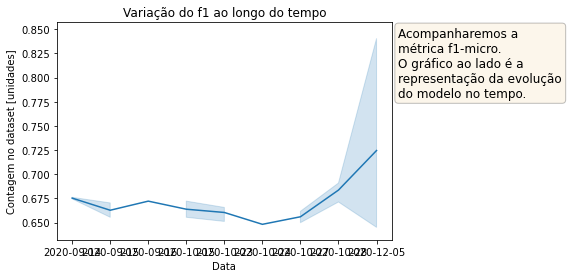

<Figure size 1080x360 with 0 Axes>

In [30]:
df_result = pd.read_csv(path_processed+"model_evaluation.csv", index_col=0)
df_result_graph = df_result[['precision', 'recall', 'f1-score', 'accuracy','date']]

# ---------------------------
# Gráfico--------------------
sns.axes_style("ticks")
ax = sns.lineplot(x='date', y='f1-score', data=df_result_graph)

y = df_result_graph["f1-score"]

y_max = y.max()*1.02
y_min = y.min()*.98
ax.set(ylim=(y_min, y_max))
ax.set(title="Variação do f1 ao longo do tempo", xlabel="Data", ylabel="Contagem no dataset [unidades]")

for p, label in zip(ax.patches, y.sort_index()):
    ax.annotate(str(label), (p.get_x()+.25, p.get_height()+.1), fontsize=12, color='black', ha='left', va='bottom')
    
textstr = f"""Acompanharemos a
métrica f1-micro.
O gráfico ao lado é a
representação da evolução
do modelo no tempo."""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)

plt.figure(figsize=(15, 5))

ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

### Salvando o modelo

Salvaremos o modelo em um arquivo pickle.

In [31]:
model_name = str(model)[:str(model).find("(")]
model_hash = str(result.index.values)[-6:-1]

filename = path_model+"model_"+model_name+"_"+model_hash

print("Salvando modelo sob o nome model_"+filename+".gz")

joblib.dump(model, filename+".gz", compress=("gzip", 6))

# pickle.dump(model_rf, open(filename, 'wb'))

# save_model(model_rf, filename)

Salvando modelo sob o nome model_../models/model_LGBMClassifier_31253.gz


['../models/model_LGBMClassifier_31253.gz']

# Realizando a previsão

In [32]:
X_test_encoded = pd.read_parquet(path_processed+"X_test_encoded.pqt")
X_test_encoded.head()

,area_percentage,age,geo_level_2_id,geo_level_3_id,height_percentage,geo_level_1_id,other_floor_type_q,other_floor_type_x,other_floor_type_j,count_floors_pre_eq_2,...,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_rental,has_secondary_use_other,has_secondary_use_industry,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police
building_id,,,,,,,,,,,,,,,,,,,,,
300051,-0.231785,-0.088832,-0.254597,1.384702,0.294845,0.385835,0.759411,-0.447303,-0.424833,-1.227318,...,0,0,0,0,0,0,0,0,0,0
99355,1.134266,-0.020866,-1.357066,1.571189,-0.226419,-0.983414,0.759411,-0.447303,-0.424833,0.814785,...,0,0,0,0,0,0,0,0,0,0
890251,-0.914810,-0.292732,-1.652673,1.038329,-0.226419,1.008221,0.759411,-0.447303,-0.424833,0.814785,...,0,0,0,0,0,0,0,0,0,0
745817,2.500317,-0.360698,-1.604213,-1.542599,-1.268946,1.506130,-1.316810,-0.447303,2.353869,-1.227318,...,0,0,1,0,0,0,0,0,0,0
421793,-0.004110,-0.156799,-0.998461,0.469543,0.816109,0.385835,0.759411,-0.447303,-0.424833,-1.227318,...,0,0,0,0,0,0,0,0,0,0


## Aplicando previsão

In [33]:
print(model, grid_search.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.075, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_leaves=100, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) {'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.075, 'max_depth': 10, 'n_estimators': 1500, 'n_jobs': -1, 'num_leaves': 100}


In [34]:
y_test = model.predict(X_test_encoded)

y_test = pd.DataFrame(data=y_test, columns=["damage_grade"], index=X_test_encoded.index)

y_test

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,2
1049160,2


In [35]:
y_test.to_csv(path_processed+"y_test.csv")